In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import random
import scipy
from scipy import optimize
from scipy import linalg

import lies

In [2]:
img0 = 'MouldShotTest1_l.JPG'
img1 = 'MouldShotTest1_r.JPG'
img2 = 'MouldShotTest2_l.JPG'

In [3]:
def imgval(I, p):
    h,w = I.shape
    x = int(p[0] / p[2])
    y = int(p[1] / p[2])
    if x < 0 or x >= w or y < 0 or y >= h:
        return math.nan
    return float(I[y,x])

def slamResiduals(Ii, Ij, p, xi, Ki, Kj):
    four, k = p.shape
    r = 0
    xim = lies.so3exp(xi[3:])
    pi = Ki @ p
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    bad = 0

    for i in range(k):
        ri = imgval(Ii, pi[:, i]) - imgval(Ij, pj[:, i])
        if math.isnan(ri):
            bad += 1
        else:
            r += ri * ri
    if bad > k/2:
        return math.inf

    #print("bad: ", bad, "/", k)

    return r / (k - bad)

def slamResidualMatches(p, xi, Kj, ref):
    xim = lies.so3exp(xi)
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    if not (pj[2,:] > 0).all():
        print ("point is behind camera")
        return math.inf
    pjn = pj[:1,:] / pj[2,:]
    
    return np.linalg.norm(pjn - ref)
    


In [4]:
px0 = cv.imread(img0, 0)
px1 = cv.imread(img1, 0)
px2 = cv.imread(img2, 0)

In [17]:
#Camera matrices

# TODO calibrate camera
K_LG_K8 = np.array([[3.96326391e+03, 0.00000000e+00, 1.65501115e+03],
 [  0.00000000e+00, 4.00971285e+03, 1.26673430e+03],
 [  0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]) 

K_IPHONE_6_JOE = np.array([[  2.95881214e+03, 0.00000000e+00, 1.22060267e+03],
 [  0.00000000e+00, 2.97470270e+03, 1.52957665e+03],
 [  0.00000000e+00, 0.00000000e+00, 1.00000000e+00]] )
K_IPHONE_6_FRANK = np.array([[3.02750000e+03, 0.00000000e+00, 1.63200000e+03],
 [  0.00000000e+00, 3.02750000e+03, 1.22400000e+03],
 [  0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

K0 = K_IPHONE_6_JOE
K1 = K_IPHONE_6_JOE

# Inverse of camera matrices
L0 = np.linalg.inv(K0) # require square camera matrix (so without the fourth all zero column), that will return 1 on the z coordinate
L1 = np.linalg.inv(K1)


In [18]:
# TODO measure camera distance in stereo frame
trans01 = np.array([0.09, 0, 0, 0, 0, 0])
B = np.linalg.norm(trans01)

In [19]:
# Find keypoints
sift = cv.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)

In [26]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params_sift = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Find matches between the two images by the means of some dark magic
flann = cv.FlannBasedMatcher(index_params_sift, search_params)
matches = flann.knnMatch(des0, des1, k=2)

good = []
pts1 = []
pts0 = []

# ratio test as per Lowe's paper
lowe = 0.6
for i, (m, n) in enumerate(matches):
    if m.distance < lowe * n.distance:
        p1 = kp1[m.trainIdx].pt
        p0 = kp0[m.queryIdx].pt
        if (abs(p0[0] - p1[0]) >= abs(p0[1] - p1[1])):
            good.append(m)
            pts1.append(p1)
            pts0.append(p0)

In [ ]:
# Find keypoints, but with ORB
orb = cv.ORB_create()
kp0, des0 = orb.detectAndCompute(px0, None)
kp1, des1 = orb.detectAndCompute(px1, None)

In [ ]:
# FLANN parameters
FLANN_INDEX_LSH = 6
index_params_orb = dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)

# Find matches between the two images by the means of some dark magic
flann = cv.FlannBasedMatcher(index_params_orb, search_params)
matches = flann.knnMatch(des0, des1, k=2)

good = []
pts1 = []
pts0 = []

# ratio test as per Lowe's paper
lowe = 0.8
for i, (m, n) in enumerate(matches):
    if m.distance < lowe * n.distance:
        good.append(m)
        pts1.append(kp1[m.trainIdx].pt)
        pts0.append(kp0[m.queryIdx].pt)
        
# umm WTF? u need to run this TWICE to make it work?

In [27]:
# Finding world points of keypoints

# Constructing depth map from two images with known translation of camera.

pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
k, two = pts0.shape

# screen points with homogeneous coordinates
pts0hom = np.array([pts0[:,0], pts0[:,1], np.ones((k))])
pts1hom = np.array([pts1[:,0], pts1[:,1], np.ones((k))])

# disparity and depth
disp = np.linalg.norm((L1 @ pts1hom) - (L0 @ pts0hom), axis=0)
depth = B / disp # consider translation direction in B maybe?

# world points
p = L0 @ pts0hom * depth
# obviously not working, as my camera calibration and translation is bad, need to test if it works with proper measurements
#print(p.transpose()[1000:1015])

197
(3264, 2448)
(391, 2025) (326, 1969) 0.02893097323562949 3.110852831219722
(1636, 2751) (1453, 2711) 0.06329400463459584 1.4219356243862462
(1102, 3181) (924, 3135) 0.062114938596321174 1.4489268126770771
(1028, 3239) (844, 3193) 0.06408092235683961 1.4044741662554103
(1096, 2652) (965, 2602) 0.047357743753918755 1.9004283748748627
(2084, 3148) (1920, 3116) 0.056461893493783985 1.5939954264889875
(392, 2021) (328, 1964) 0.028896990536263673 3.1145111767627283
(229, 1966) (161, 1909) 0.029922356598317434 3.007784487304078
(1602, 2729) (1421, 2689) 0.0626336526743507 1.4369272133613913
(2194, 1007) (350, 2647) 0.8320792573308285 0.10816277320589024
(2343, 609) (2284, 563) 0.02523386384107597 3.5666357148799768
(647, 2031) (585, 1975) 0.028168796239428126 3.195024708724548
(1169, 3113) (992, 3069) 0.06162283449798408 1.460497569337617
(1127, 3098) (953, 3052) 0.06080653992163063 1.4801039512525265
(1120, 439) (1070, 425) 0.017541804869651945 5.130600908444932
(1635, 2750) (1453, 2711)

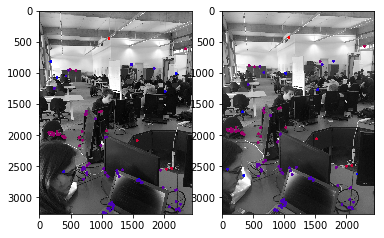

In [42]:
#print (pts0[:15,], pts1[:15,], disp[:15], depth[:15])
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    #colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = random.randint(0, nn-1)
    colour = (depth[j] * 50, 0, 256 - depth[j] * 50)
    print(tuple(pts0[j,:].astype(int).tolist()), tuple(pts1[j,:].astype(int).tolist()), disp[j], depth[j])
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [43]:
# Trying to determine camera movement between images, 
xi0 = np.array([.0,.00,0.0,0.0,0.0,0.0])

xi = scipy.optimize.fmin(lambda xi: slamResiduals(px0, px2, p, xi, K0, K1), xi0)
#xi = slam.slamStepIterate(px0, px2, p, xi0, 100)

print(xi)
# FAIL (obviously)

Optimization terminated successfully.
         Current function value: 6963.350254
         Iterations: 72
         Function evaluations: 389
[ 1.16698973e-17  2.50000000e-04  3.30984103e-17 -1.06938956e-16
  3.43276196e-17  8.74575627e-18]


In [44]:
# Elimination of outlier points using fundamental matrix

F, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
print(F)

# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]

[[-1.48987128e-09 -6.75427372e-07  4.68870957e-04]
 [ 5.67312533e-07  4.68003958e-08 -1.75225749e-02]
 [-3.87240985e-04  1.74725040e-02  1.00000000e+00]]


157
(3264, 2448)
(157, 1956) (89, 1899) 0.029922356598317434 3.007784487304078
(257, 1969) (189, 1911) 0.029881816136436187 3.0118651285809603
(734, 2530) (597, 2476) 0.030972794850033843 2.905775873174121
(780, 1580) (694, 1525) 0.04835273542789845 1.8613217887993987
(1155, 3085) (981, 3039) 0.04755638192584174 1.892490478782507
(2222, 3073) (2069, 3042) 0.03668906581718624 2.453046922711271
(1841, 918) (1601, 863) 0.025748320441048713 3.4953736188757154
(397, 2019) (332, 1962) 0.029406374121348493 3.060560939223773
(1088, 2641) (957, 2592) 0.275103258193783 0.32714988761275926
(1103, 2649) (970, 2599) 0.04653403212195119 1.934068377400395
(411, 2027) (346, 1969) 0.028896990536263673 3.1145111767627283
(315, 1986) (246, 1929) 0.029663561917203173 3.0340253895067515
(729, 2527) (593, 2475) 0.04572043836924059 1.9684850629199004
(1062, 2034) (929, 1985) 0.029022317672878818 3.1010617764722648
(1986, 2841) (1852, 2803) 0.057525232899171344 1.564530823504001
(411, 2027) (346, 1969) 0.0288

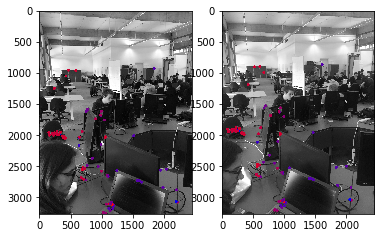

In [48]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    #colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = random.randint(0, nn-1)
    colour = (depth[j] * 75 - 25, 0, 280 - depth[j] * 75)
    print(tuple(pts0[j,:].astype(int).tolist()), tuple(pts1[j,:].astype(int).tolist()), disp[j], depth[j])
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [49]:
# Trying to determine camera movement between images, 
xi0 = np.array([.0,.00,0.0,0.0,0.0,0.0])

xi = scipy.optimize.fmin(lambda xi: slamResiduals(px0, px2, p, xi, K0, K1), xi0)
#xi = slam.slamStepIterate(px0, px2, p, xi0, 100)

print(xi)
# still FAIL
# let's try something else

Optimization terminated successfully.
         Current function value: 6963.350254
         Iterations: 72
         Function evaluations: 389
[ 1.16698973e-17  2.50000000e-04  3.30984103e-17 -1.06938956e-16
  3.43276196e-17  8.74575627e-18]


In [50]:
# Find matches again, but this time between three images

# Find keypoints. This will be useful in slam even if there aren't many matches.
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)
kp2, des2 = sift.detectAndCompute(px2, None)
# would compressing the images result in more or less matches? It would defo make the matcher run faster
# can this find matches between images taken by two different cameras

# find matckes between keypoints in pairs of images. 
# The matches will reference the keypoints, so we can pick up some matches between all three images
flann = cv.FlannBasedMatcher(index_params_sift, search_params)
# OpenCV is terribly documented. The knnMatch function doesn't even exist in the documentation
matches01 = flann.knnMatch(des1, des0, k=2)
matches02 = flann.knnMatch(des2, des0, k=2)

good01 = {}

# ratio test as per Lowe's paper
# ^this comment is from the OpenCV tutorial. I have not read, or even found, Lowe's paper
lowe = 0.8
# the ratio test isn't really good to remove outliers. We will construct a fundamental matrix and use that
for i, (m, n) in enumerate(matches01):
    if m.distance < lowe * n.distance:
        good01[m.trainIdx] = m
        
pts0 = []
pts1 = []
pts2 = []
        
# Finding matches between all three images. 
for i, (m, n) in enumerate(matches02):
    if m.distance < lowe * n.distance:
        if m.trainIdx in good01:
            pts0.append(kp0[m.trainIdx].pt)
            pts1.append(kp1[good01[m.trainIdx].queryIdx].pt)
            pts2.append(kp2[m.queryIdx].pt)
        
pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(pts0.shape)

(774, 2)


In [51]:
pts0orig = pts0
pts1orig = pts1
pts2orig = pts2

# we should already know this matrix? Wierdly, we get something different than last time.
F01, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
print(F01)

# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


F02, mask = cv.findFundamentalMat(pts2,pts0,cv.FM_LMEDS)
print(F02)

pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[-1.05672949e-09 -1.41967626e-06  1.29482516e-03]
 [ 1.36331754e-06  9.63793887e-08 -1.44704565e-02]
 [-1.31286020e-03  1.42124773e-02  1.00000000e+00]]
[[-5.15487471e-09  4.52725542e-07 -5.36147169e-04]
 [-1.59535314e-06  1.40902153e-07  8.21773752e-03]
 [ 1.81971482e-03 -8.49836618e-03  1.00000000e+00]]


470
(3264, 2448)


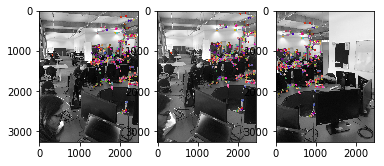

In [52]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
px2p = cv.cvtColor(px2, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    px2p = cv.circle(px2p, tuple(pts2[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(131),plt.imshow(px0p)
plt.subplot(132),plt.imshow(px1p)
plt.subplot(133),plt.imshow(px2p)
plt.show()

In [ ]:
# calculate essential matrix
E = K0.transpose() @ F02 @ K0
print(E)

In [ ]:
Ra, Rb, t = cv.decomposeEssentialMat(E)
print(t)
print(Ra)
print(Rb)

rota = lies.so3log(Ra)
rotb = lies.so3log(Rb)

t = t[:,0]

## Trying to get camera movement and rotation based on the essential matrix
## In theory, we can get the direction of the movement (not magnitude, and may be opposite direction)
## We can also get the rotation matrix but there are two possible solutions and we can not tell which one is correct
#
#W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
#Wt = W.transpose()
#
## get null space of essential matrix 
## there's another formula on Wikipedia, but that doesn't give a skew-symmetric cross product matrix. Maybe because of camera calibration
#U,s,Vt = scipy.linalg.svd(E)
#nullmask = (s <= 1e-7)
#t = scipy.compress(nullmask, Vt, axis=0)[0]
#
## finding rotation matrix and corresponding so(3) lie algebras
#Ra = U @ Wt @ Vt
#Rb = U @ W @ Vt
#rota = lies.so3log(Ra)
#rotb = lies.so3log(Rb)
#
#print("t=",t)
## Eigenvalues should be two identical and a zero. They do not seem identical to me
#print("s=",s)
## Multiplying the rotation matrix with the cross product matrix does not return the original E??
#print("[t]× R=",np.transpose(np.cross(t, Ra.transpose())))
#print("rota=",rota)

In [ ]:
H, mask = cv.findHomography(pts0orig, pts1orig)
pts0h = pts0orig[mask.ravel()==1]
pts1h = pts1orig[mask.ravel()==1]
pts2h = pts2orig[mask.ravel()==1]

n, Rs, ts, ns = cv.decomposeHomographyMat(H, K0)

print (Rs)
print ()
print (ts)
print ()
print (ns)

In [ ]:
# Finding world points of keypoints again

k, two = pts0.shape

# image points with homogeneous coordinates
pts0hom = np.array([pts0[:,0], pts0[:,1], np.ones((k))])
pts1hom = np.array([pts1[:,0], pts1[:,1], np.ones((k))])

# disparity and depth
disp = np.linalg.norm((L1 @ pts1hom) - (L0 @ pts0hom), axis=0)
depth = B / disp

# world points
p = L0 @ pts0hom * depth

# Reference for residuals matching
ref = pts2.transpose()

In [ ]:
# SLAM match image intensities using translation direction and rotation obtained from SVD of essential matrix
# doesn't work, probably slamResiduals is bad
s = scipy.optimize.fmin(lambda l: slamResiduals(px0, px2, p, np.concatenate([t * l[0], rota]), K0, K0), [0.0])

In [ ]:
# Slam match residuals using translation direction and rotation obtained from SVD of essential matrix
#no idea how to determine if we need Ra or Rb

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l, rota]), K0, ref), 0.0)
print(t * s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l, rotb]), K0, ref), 0.0)
print(t * s)

In [ ]:
# SLAM match residuals without using essential matrix decomposed translation vector

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([t, rota]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([t, rotb]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([-t, rota]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([-t, rotb]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.array([0, 0, 0, 0, 0, 0]))
print(xi)

# seems to converge to different values from different starting points
# Maximum number of function evaluations has been exceeded. often
# maybe use Gauss-Newton from original LSD-SLAM paper?
# we need accurate transformation measurements and camera calibration to proceed!

In [ ]:
# Finding world points of keypoints for homeography inliers

k, two = pts0h.shape

# image points with homogeneous coordinates
pts0hom = np.array([pts0h[:,0], pts0h[:,1], np.ones((k))])
pts1hom = np.array([pts1h[:,0], pts1h[:,1], np.ones((k))])

# disparity and depth
disp = np.linalg.norm((L1 @ pts1hom) - (L0 @ pts0hom), axis=0)
depth = B / disp

# world points
p = L0 @ pts0hom * depth

# Reference for residuals matching
ref = pts2h.transpose()

In [ ]:
# SLAM residuals matching based on homeography output:

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([l * ts[0][:,0], lies.so3log(Rs[0])]), K0, ref), 1.0)
xi = np.concatenate([s * ts[0][:,0], lies.so3log(Rs[0])])
print(xi)
print(s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([l * ts[1][:,0], lies.so3log(Rs[1])]), K0, ref), 1.0)
xi = np.concatenate([s * ts[1][:,0], lies.so3log(Rs[1])])
print(xi)
print(s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([l * ts[2][:,0], lies.so3log(Rs[2])]), K0, ref), 1.0)
xi = np.concatenate([s * ts[2][:,0], lies.so3log(Rs[2])])
print(xi)
print(s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([l * ts[3][:,0], lies.so3log(Rs[3])]), K0, ref), 1.0)
xi = np.concatenate([s * ts[3][:,0], lies.so3log(Rs[3])])
print(xi)
print(s)